### Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Read in Raw file

In [2]:
# File path for ETH‑USD minute data
ethusd_file_path = "../../data/raw/minute/ethusd.csv"

In [3]:
# Load the minute-level data
data = pd.read_csv(ethusd_file_path)

# Convert Unix Timestamp (milliseconds) to datetime (keeping it as a column)
data['time'] = pd.to_datetime(data['time'], unit='ms')

# Sort by time
data = data.sort_values('time')

# Set 'time' as index temporarily to resample
data = data.set_index('time')

# Check the data
data.head()

,open,close,high,low,volume
time,,,,,
2016-03-09 16:04:00,10.297,10.097,10.297,10.097,0.03
2016-03-09 17:49:00,11.197,11.197,11.197,11.197,0.01
2016-03-09 18:56:00,11.097,11.097,11.097,11.097,0.02
2016-03-09 20:16:00,11.195,11.195,11.195,11.195,0.01
2016-03-09 20:21:00,10.870,10.870,10.870,10.870,1.00


In [4]:
# Calculate number of records per day
count = data['open'].resample('1D').apply(lambda x: x.count())

# find where count is zero
zero_count = count[count == 0].index

#### Dropping days prior to Jun-16 and days without transactions

In [5]:
# Drop records earlier than 2016-06-01
data = data.loc[data.index >= '2016-06-01']

# Drop records where count is zero
data = data.loc[~data.index.normalize().isin(zero_count)]

### Compute intraday log returns and daily RV

In [7]:
data.head()

,open,close,high,low,volume,Log Return
time,,,,,,
2016-06-01 00:01:00,14.131,14.218,14.280,14.131,42.58000,0.006138
2016-06-01 00:02:00,14.212,14.212,14.212,14.212,2.40000,-0.000422
2016-06-01 00:04:00,14.198,14.198,14.198,14.198,20.00000,-0.000986
2016-06-01 00:05:00,14.140,14.140,14.140,14.140,500.00000,-0.004093
2016-06-01 00:06:00,14.140,14.140,14.140,14.140,29.32104,0.000000


In [11]:
# Calculate intraday log returns
data['Log Return'] = np.log(data['close'] / data['close'].shift(1))

# Drop records with missing log returns (the first record)
data.dropna(subset=['Log Return'], inplace=True)
data.head()

,open,close,high,low,volume,Log Return
time,,,,,,
2016-06-01 00:04:00,14.198,14.198,14.198,14.198,20.00000,-0.000986
2016-06-01 00:05:00,14.140,14.140,14.140,14.140,500.00000,-0.004093
2016-06-01 00:06:00,14.140,14.140,14.140,14.140,29.32104,0.000000
2016-06-01 00:07:00,14.141,14.141,14.141,14.141,1.00000,0.000071
2016-06-01 00:08:00,14.150,14.150,14.150,14.150,1.00000,0.000636


In [15]:
# Calculate time gap between consecutive records
data['Time Gap'] = data.index.to_series().diff().dt.total_seconds()
data.head()

,open,close,high,low,volume,Log Return,Time Gap
time,,,,,,,
2016-06-01 00:04:00,14.198,14.198,14.198,14.198,20.00000,-0.000986,NaN
2016-06-01 00:05:00,14.140,14.140,14.140,14.140,500.00000,-0.004093,60.0
2016-06-01 00:06:00,14.140,14.140,14.140,14.140,29.32104,0.000000,60.0
2016-06-01 00:07:00,14.141,14.141,14.141,14.141,1.00000,0.000071,60.0
2016-06-01 00:08:00,14.150,14.150,14.150,14.150,1.00000,0.000636,60.0


In [16]:
# Use Tick-by-Tick Realized Volatility (Time-Weighted Approach) to calculate daily realized variance
data['Realized Variance'] = data['Log Return'].pow(2) / data['Time Gap']
rv_1d = data['Realized Variance'].resample('1D').sum()

In [17]:
# Aggregate minute data into daily data:
daily_data = data.resample('1D').agg({
    'open': 'first',        # First open price of the day
    'close': 'last',        # Last close price of the day
    'high': 'max',          # Highest price of the day
    'low': 'min',           # Lowest price of the day
    'volume': 'sum',        # Total volume for the day
})

# Add daily realized variance and rename the column
daily_data['1D RV'] = rv_1d
daily_data.rename(columns={'1D RV': 'RV_d,t'}, inplace=True)

In [18]:
# Calculate daily returns from the daily close price
daily_data['daily_return'] = daily_data['close'].pct_change(fill_method=None)

# Drop records with missing daily returns (the first record)
daily_data.dropna(subset=['daily_return'], inplace=True)

In [19]:
daily_data.head()

,open,close,high,low,volume,"RV_d,t",daily_return
time,,,,,,,
2016-06-02,13.940,13.770,14.029,13.608,45433.303588,0.000024,-0.012549
2016-06-03,13.818,13.940,13.990,13.420,57902.825013,0.000046,0.012346
2016-06-04,13.940,13.701,13.962,13.404,40804.625605,0.000019,-0.017145
2016-06-05,13.787,13.895,13.969,13.686,16549.050051,0.000012,0.014160
2016-06-06,13.970,13.949,14.193,13.801,33303.742772,0.000023,0.003886


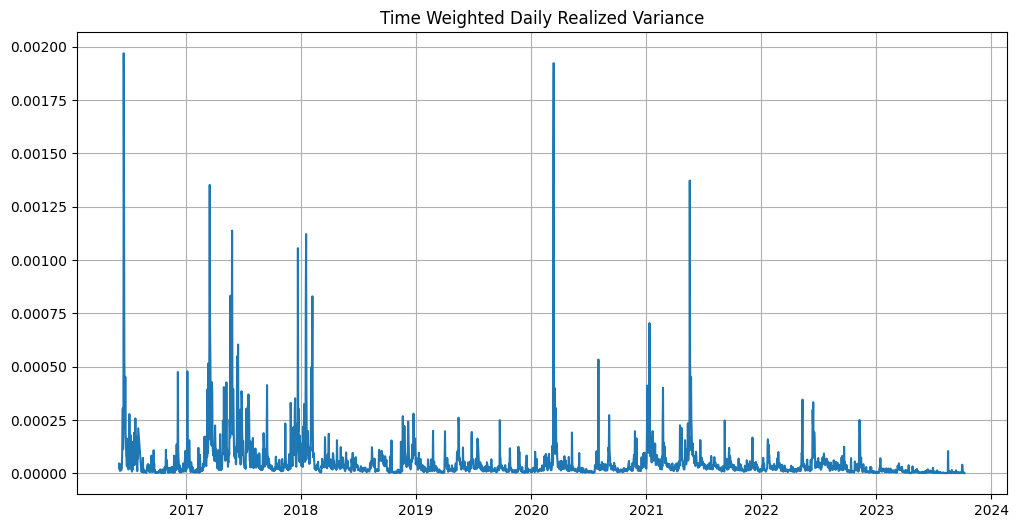

In [21]:
# Plot the daily realized variance
plt.figure(figsize=(12, 6))
plt.plot(daily_data['RV_d,t'])
plt.title('Time Weighted Daily Realized Variance')
plt.grid()
plt.show()

In [22]:
# Compute rolling averages for realized variance: 7-day and 30-day
daily_data['RV_w,t'] = daily_data['RV_d,t'].rolling(window=7).mean()
daily_data['RV_m,t'] = daily_data['RV_d,t'].rolling(window=30).mean()

# Apply logarithmic transformation to the realized variance measures
daily_data['ln_RV_d,t'] = np.log(daily_data['RV_d,t'])
daily_data['ln_RV_w,t'] = np.log(daily_data['RV_w,t'])
daily_data['ln_RV_m,t'] = np.log(daily_data['RV_m,t'])

# Reset the index so that 'time' becomes a column again
daily_data = daily_data.reset_index()

In [23]:
# Save the merged data to a CSV file
daily_data.to_csv("../../data/ethusd_time_weighted.csv", index=False)
